In [23]:
#Build - Train - Test Recurrent Neural Networks
# Part IV: LSTM with Time-series Data

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [25]:
# Read and prepare data
def load_temperature_data():
    url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
    df = pd.read_csv(url, skiprows=1)
    # Extract monthly temperature columns
    temp_columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    df_temps = df[temp_columns]
    # Convert to long format
    df_long = df_temps.melt(var_name='Month', value_name='Temperature')
    df_long['Year'] = np.repeat(df['Year'].values, 12)
    # Create datetime index
    df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'])
    df_long = df_long.sort_values('Date')
    # Remove missing values (marked as '***')
    df_long = df_long[df_long['Temperature'] != '***']
    df_long['Temperature'] = df_long['Temperature'].astype(float)
    return df_long.set_index('Date')[['Temperature']]


In [26]:
# Data preprocessing
def preprocess_data(df, test_split=0.2, sequence_length=24):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length), 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split into train and test sets
    train_size = int(len(X) * (1-test_split))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler


In [27]:
def build_model(sequence_length):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    return model


In [28]:

def plot_results(history, y_test, y_pred, scaler):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    plt.plot(y_test_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Temperature Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature Anomaly (°C)')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [32]:

# Parameters
sequence_length = 24  # 2 years of monthly data
epochs = 100
batch_size = 32
validation_split = 0.1


In [33]:

# Load and preprocess data
df = load_temperature_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(df, sequence_length=sequence_length)


C:\Users\babebe\AppData\Local\Temp\ipykernel_48100\2285154615.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'])


In [38]:

# Build and train model
model = build_model(sequence_length)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100


C:\Users\babebe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0812 - mae: 0.2240 - val_loss: 0.0201 - val_mae: 0.1108
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199 - mae: 0.1063 - val_loss: 0.0163 - val_mae: 0.0944
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mae: 0.0908 - val_loss: 0.0160 - val_mae: 0.0888
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mae: 0.0872 - val_loss: 0.0145 - val_mae: 0.0893
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.0832 - val_loss: 0.0131 - val_mae: 0.0821
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135 - mae: 0.0852 - val_loss: 0.0126 - val_mae: 0.0807
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mae: 0.0817 - val_loss: 0.0122 - val_mae: 0.0802
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - mae: 0.0811 - val_loss: 0.0133 - val_mae: 0.0859
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


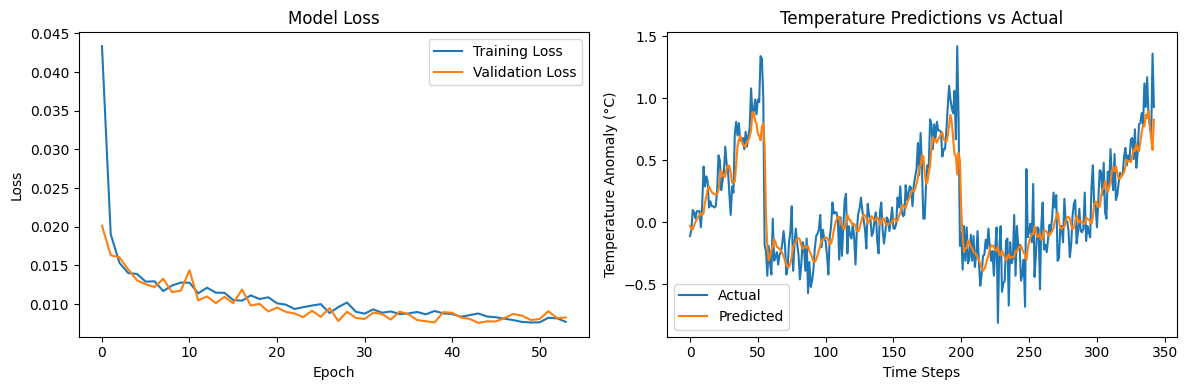

In [39]:

# Make predictions
y_pred = model.predict(X_test)
# Plot results
plot_results(history, y_test, y_pred, scaler)


In [40]:
# Calculate and print metrics
mse = np.mean((y_test - y_pred.flatten())**2)
mae = np.mean(np.abs(y_test - y_pred.flatten()))
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')


MSE: 0.0082
MAE: 0.0670
